# Hannah Zhao - Week 4 DenseNet Model with MIL
## MIL (Multiple Instance Learning) stops you from punishing for “normal‐looking” patches in High-grade cases by moving supervision up to the case level
### Goal: trying to figure out why model is focusing on poor image quality patches
#### overall results:  
#### next step:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Standard library imports
import os
import re
import random
import shutil
from datetime import datetime
from collections import OrderedDict

# Data handling and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and TorchVision libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
from PIL import Image

# Scikit-Learn for evaluation metrics and data splitting|
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Imbalanced-learn for oversampling to address class imbalance
from imblearn.over_sampling import RandomOverSampler

from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
from PIL import Image
from PIL import UnidentifiedImageError
from tqdm import tqdm

import os, re, random
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split

In [ ]:
# Base path to your STAT 390 folder
base_dir = "/content/drive/MyDrive/STAT 390"

# Patch folders
filtered_patches_dir = os.path.join(base_dir, "CMIL_SP2025_Patches_Apr27_Filtered60px")

# Labels CSV
csv_file_path = os.path.join(base_dir, "case_grade_match.csv")

# Checkpoint folder
checkpoint_dir = os.path.join(base_dir, "Checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

# Load labels
labels = pd.read_csv(csv_file_path)


In [ ]:
!ls "/content/drive/MyDrive/STAT 390/CMIL_SP2025_Patches_Apr27_Filtered60px" | head -n 10


case_064_match_2_h&e_patch12.png
case_064_match_2_h&e_patch13.png
case_064_match_2_h&e_patch14.png
case_064_match_2_h&e_patch16.png
case_064_match_2_h&e_patch24.png
case_064_match_2_h&e_patch28.png
case_064_match_2_h&e_patch29.png
case_064_match_2_h&e_patch31.png
case_064_match_2_h&e_patch32.png
case_064_match_2_h&e_patch33.png


In [ ]:
# def filter_and_save_min_width(patches_dict, min_width=60, stain_keyword="h&e", save_dir=None):
#     filtered_patches = {}

#     for case_id, paths in patches_dict.items():
#         valid_paths = []
#         for path in paths:
#             if stain_keyword.lower() not in os.path.basename(path).lower():
#                 continue  # skip non-H&E

#             try:
#                 with Image.open(path) as img:
#                     width, _ = img.size
#                     if width >= min_width:
#                         # Save to new folder
#                         rel_path = os.path.relpath(path, filtered_patches_dir)
#                         save_path = os.path.join(save_dir, rel_path)
#                         os.makedirs(os.path.dirname(save_path), exist_ok=True)
#                         shutil.copy2(path, save_path)  # or .move if you want to delete old

#                         valid_paths.append(save_path)
#             except Exception as e:
#                 print(f"⚠️ Could not read {path}: {e}")

#         if valid_paths:
#             filtered_patches[case_id] = valid_paths

#     return filtered_patches

In [ ]:
def group_patches_recursive(root_dir):
    case_patches = {}
    for root, _, files in os.walk(root_dir):
        for filename in files:
            match = re.search(r"case_(\d+)", filename)
            if match and filename.endswith(".png"):
                case_num = int(match.group(1))
                if case_num not in case_patches:
                    case_patches[case_num] = []
                case_patches[case_num].append(os.path.join(root, filename))
    return case_patches

patches = group_patches_recursive(filtered_patches_dir)
# filtered_patches = filter_and_save_min_width(
#     patches_dict=patches,
#     min_width=60,
#     stain_keyword="h&e",
#     save_dir=filtered_save_dir
# )

In [ ]:
# Validation / Test transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Training transform (augmented)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# === Load and filter case labels ===
case_nums = list(patches.keys())
dataset = labels.loc[[(x-1) for x in case_nums]]  # Adjust indexing
valid_classes = [1.0, 3.0, 4.0]
filtered_dataset = dataset[dataset['Class'].isin(valid_classes)]

X = filtered_dataset.Case.reset_index(drop=True)
y = filtered_dataset.Class.reset_index(drop=True)
case_to_class = {c: 0 if cl == 1.0 else 1 for c, cl in zip(X, y)}  # Binary class map

# === Stratified split: 60% train, 20% val, 20% test per class ===
cases_by_class = defaultdict(list)
for case_id, label in case_to_class.items():
    cases_by_class[label].append(case_id)

train_cases, val_cases, test_cases = [], [], []
for label, cases in cases_by_class.items():
    train_c, temp_c = train_test_split(cases, test_size=0.4, random_state=42)
    val_c, test_c = train_test_split(temp_c, test_size=0.5, random_state=42)
    train_cases += train_c
    val_cases += val_c
    test_cases += test_c

# === Subset patch dictionary ===
train_patches = {c: patches[c] for c in train_cases if c in patches}
val_patches   = {c: patches[c] for c in val_cases if c in patches}
test_patches  = {c: patches[c] for c in test_cases if c in patches}

# === Optional: filter to just H&E stain ===
def filter_by_stain(d, keyword):
    out, dropped = {}, []
    for c, paths in d.items():
        filtered = [p for p in paths if keyword.lower() in os.path.basename(p).lower()]
        if filtered:
            out[c] = filtered
        else:
            dropped.append(c)
    if dropped:
        print(f"⚠️ Dropped cases with no '{keyword}' patches: {dropped}")
    return out

stain = "h&e"
train_patches = filter_by_stain(train_patches, stain)
val_patches   = filter_by_stain(val_patches, stain)
test_patches  = filter_by_stain(test_patches, stain)

# === Optional: report class distribution ===
def summarize_cases(case_list, label_map):
    labels = [label_map[c] for c in case_list]
    return Counter(labels)

print(f"\n📊 Case counts:")
print(f"Train: {summarize_cases(train_cases, case_to_class)}")
print(f"Val:   {summarize_cases(val_cases, case_to_class)}")
print(f"Test:  {summarize_cases(test_cases, case_to_class)}")


📊 Case counts:
Train: Counter({1: 13, 0: 6})
Val:   Counter({1: 4, 0: 2})
Test:  Counter({1: 5, 0: 2})


In [ ]:
class MILDataset(Dataset):
    def __init__(self, case_patches, labels_df, transform=None, emergency_cap=800):
        self.transform = transform
        self.emergency_cap = emergency_cap  # only cap if massive
        self.bags, self.labels = [], []
        for case, paths in case_patches.items():
            raw = labels_df.loc[labels_df['Case'] == case, 'Class'].item()
            bag_lbl = 0 if raw == 1 else 1
            self.bags.append(paths)
            self.labels.append(bag_lbl)

    def __len__(self): return len(self.bags)

    def __getitem__(self, idx):
        paths = self.bags[idx]
        imgs = []
        for p in paths:
            try:
                img = Image.open(p).convert('RGB')
                if self.transform:
                    img = self.transform(img)
                imgs.append(img)
            except:
                continue

        if len(imgs) == 0:
            raise ValueError(f"No good patches in case {paths}")

        # Only sample if emergency_cap is set
        if self.emergency_cap is not None and len(imgs) > self.emergency_cap:
            imgs = random.sample(imgs, self.emergency_cap)

        return torch.stack(imgs), torch.tensor(self.labels[idx], dtype=torch.long)


class AttentionPool(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, return_weights=False):
        weights = self.attention(x)     # (B, M, 1)
        weights = torch.softmax(weights, dim=1)
        weighted_x = (weights * x).sum(dim=1)  # (B, D)

        if return_weights:
            return weighted_x, weights.squeeze(-1)  # (B, D), (B, M)
        return weighted_x


# using Densenet to extract features at the patch-level, and adaptaive pooling for patch-level feature pooling
# the patch features are passed into Attentionpool which learns the weights across patches and combines them into a single bag label

class AttnMIL(nn.Module):
    def __init__(self, base_model, num_classes=2, embed_dim=512):
        super().__init__()
        self.features = base_model.features
        self.pool = nn.AdaptiveAvgPool2d((2,2))  # richer than (1,1)
        self.patch_projector = nn.Linear(base_model.classifier.in_features * 4, embed_dim)
        self.attention_pool = AttentionPool(embed_dim)
        self.classifier = nn.Linear(embed_dim, num_classes)

    def forward(self, x, return_patch_logits=False, return_attn_weights=False):
        if x.dim() == 4:
            x = x.unsqueeze(0)
        B, M, C, H, W = x.shape
        x = x.view(B*M, C, H, W)

        features = self.features(x)
        pooled = self.pool(features).view(B*M, -1)
        embedded = self.patch_projector(pooled).view(B, M, -1)

        if return_patch_logits:
            logits = self.classifier(embedded)  # (B, M, 2)
            return logits

        if return_attn_weights:
            bag_emb, attn_weights = self.attention_pool(embedded, return_weights=True)
            logits = self.classifier(bag_emb)
            return logits, attn_weights  # bag prediction + per-patch attention scores

        bag_emb = self.attention_pool(embedded)
        logits = self.classifier(bag_emb)
        return logits


In [ ]:
# Set up datasets
train_ds = MILDataset(train_patches, labels, transform=train_transform)
val_ds   = MILDataset(val_patches,   labels, transform=transform)
test_ds  = MILDataset(test_patches,  labels, transform=transform, emergency_cap=None)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)

In [ ]:
def save_checkpoint(model, arch, checkpoint_dir, optimizer, epoch):
    os.makedirs(checkpoint_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{checkpoint_dir}/{timestamp}_{arch}_epoch{epoch}.pth"
    checkpoint = {
        "arch": arch,
        "model_state_dict": model.state_dict(),
        "epoch": epoch,
        "optimizer_state_dict": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)
    print(f"✅ Checkpoint saved: {filename}")

def validation(model, criterion, val_loader):
    val_loss = 0
    correct_total = 0
    sample_total = 0
    model.eval()
    with torch.no_grad():
        for bags, labels in val_loader:
            bags = bags.to(device)
            labels = labels.to(device)
            outputs = model(bags)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct_total += (preds == labels).sum().item()
            sample_total += labels.size(0)
    return val_loss / sample_total, correct_total / sample_total

def train_model(model, optimizer, criterion, train_loader, val_loader, arch, checkpoint_dir, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for bags, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            bags = bags.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(bags)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        val_loss, val_acc = validation(model, criterion, val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.3f}, Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}")
        save_checkpoint(model, arch, checkpoint_dir, optimizer, epoch+1)
    return model

In [ ]:
# ------------------- Load pretrained patch model -------------------
class PatchClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        self.features = base.features
        self.pool = nn.AdaptiveAvgPool2d((2,2))
        self.classifier = nn.Linear(base.classifier.in_features * 4, 2)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).view(x.size(0), -1)
        return self.classifier(x)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

patch_model = PatchClassifier()
patch_model.load_state_dict(torch.load(
    os.path.join(checkpoint_dir, "patch_classifier_3.pth"),
    map_location=device
))
patch_model.eval()

PatchClassifier(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [ ]:

# ------------------- Inject backbone into MIL -------------------
base_model = models.densenet121(weights=None)
base_model.features = patch_model.features

model = AttnMIL(base_model=base_model).to(device)
for param in model.features.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
arch = "densenet121_simplemil"


train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [ ]:
# Train model
trained_model = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    arch=arch,
    checkpoint_dir=checkpoint_dir,
    epochs=5,
)

Epoch 1/5: 100%|██████████| 19/19 [01:27<00:00,  4.60s/it]


Epoch 1/5, Train Loss: 3.326, Val Loss: 2.232, Val Acc: 0.667
✅ Checkpoint saved: /content/drive/MyDrive/STAT 390/Checkpoints/20250519_122410_densenet121_simplemil_epoch1.pth


Epoch 2/5: 100%|██████████| 19/19 [00:28<00:00,  1.51s/it]


Epoch 2/5, Train Loss: 1.003, Val Loss: 4.394, Val Acc: 0.333
✅ Checkpoint saved: /content/drive/MyDrive/STAT 390/Checkpoints/20250519_122443_densenet121_simplemil_epoch2.pth


Epoch 3/5: 100%|██████████| 19/19 [00:28<00:00,  1.51s/it]


Epoch 3/5, Train Loss: 1.675, Val Loss: 5.455, Val Acc: 0.333
✅ Checkpoint saved: /content/drive/MyDrive/STAT 390/Checkpoints/20250519_122517_densenet121_simplemil_epoch3.pth


Epoch 4/5: 100%|██████████| 19/19 [00:28<00:00,  1.52s/it]


Epoch 4/5, Train Loss: 0.614, Val Loss: 7.700, Val Acc: 0.667
✅ Checkpoint saved: /content/drive/MyDrive/STAT 390/Checkpoints/20250519_122550_densenet121_simplemil_epoch4.pth


Epoch 5/5: 100%|██████████| 19/19 [00:30<00:00,  1.60s/it]


Epoch 5/5, Train Loss: 0.562, Val Loss: 6.952, Val Acc: 0.667
✅ Checkpoint saved: /content/drive/MyDrive/STAT 390/Checkpoints/20250519_122626_densenet121_simplemil_epoch5.pth


=== Case-Level Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.00      0.00      0.00         2
High-grade CMIL       0.71      1.00      0.83         5

       accuracy                           0.71         7
      macro avg       0.36      0.50      0.42         7
   weighted avg       0.51      0.71      0.60         7


=== Patch-Level Classification Report (weak labels) ===
                 precision    recall  f1-score   support

         Benign       0.02      0.02      0.02       249
High-grade CMIL       0.50      0.50      0.50       482

       accuracy                           0.34       731
      macro avg       0.26      0.26      0.26       731
   weighted avg       0.34      0.34      0.34       731



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


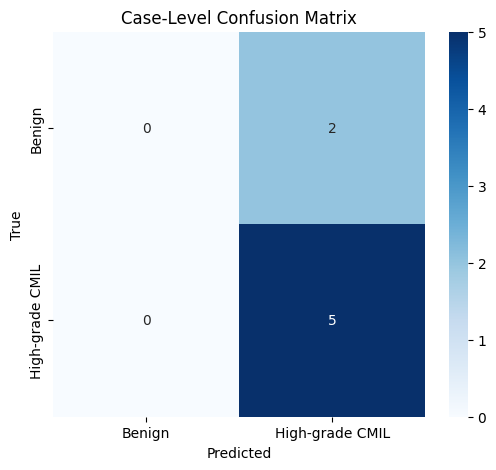

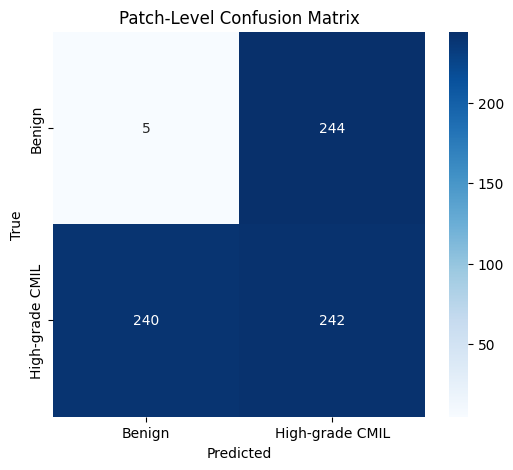

In [ ]:
# ------------------- Evaluation -------------------
model.eval()
all_preds, all_trues = [], []
all_patch_preds, all_patch_trues = [], []

with torch.no_grad():
    for X_bag, y in test_loader:
        X_bag, y = X_bag.to(device), y.to(device)

        # Case-level prediction
        bag_logits = model(X_bag)
        bag_pred = bag_logits.argmax(dim=1)
        all_preds.extend(bag_pred.cpu().numpy())
        all_trues.extend(y.cpu().numpy())

        # Patch-level prediction (weak supervision)
        patch_logits = model(X_bag, return_patch_logits=True)
        patch_pred = patch_logits.argmax(dim=2).squeeze(0).cpu().numpy()
        patch_labels = y.cpu().item() * np.ones_like(patch_pred)

        all_patch_preds.extend(patch_pred)
        all_patch_trues.extend(patch_labels)

# Reports
print("=== Case-Level Classification Report ===")
print(classification_report(all_trues, all_preds, target_names=['Benign', 'High-grade CMIL'], labels=[0,1]))

print("\n=== Patch-Level Classification Report (weak labels) ===")
print(classification_report(all_patch_trues, all_patch_preds, target_names=['Benign', 'High-grade CMIL'], labels=[0,1]))

# Confusion matrices
for name, preds, trues in [
    ("Case-Level", all_preds, all_trues),
    ("Patch-Level", all_patch_preds, all_patch_trues)
]:
    cm = confusion_matrix(trues, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign','High-grade CMIL'],
                yticklabels=['Benign','High-grade CMIL'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image

def visualize_top_attended_patches(model, test_ds, num_cases=3, top_k=5):
    model.eval()
    selected_indices = random.sample(range(len(test_ds)), num_cases)

    for idx in selected_indices:
        bag, label = test_ds[idx]
        bag = bag.unsqueeze(0).to(device)
        label = label.item()

        with torch.no_grad():
            logits, attn_weights = model(bag, return_attn_weights=True)
            pred = logits.argmax(dim=1).item()
            correct = (pred == label)
            attn_weights = attn_weights.squeeze(0).cpu().numpy()

        patch_paths = test_ds.bags[idx]
        top_indices = attn_weights.argsort()[-top_k:][::-1]

        print(f"\n🧪 Case #{idx}: True label = {label}, Predicted = {pred}, Correct = {correct}")
        print("Top patches with highest attention:")

        plt.figure(figsize=(15, 3))
        for i, patch_idx in enumerate(top_indices):
            patch_path = patch_paths[patch_idx]
            img = Image.open(patch_path)
            weight = attn_weights[patch_idx]

            print(f"  - {os.path.basename(patch_path)}: attention = {weight:.4f}")

            plt.subplot(1, top_k, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"attn={weight:.3f}")
        plt.suptitle(f"Case {idx} | True: {label} | Pred: {pred} | Correct: {correct}")
        plt.tight_layout()
        plt.show()



🧪 Case #0: True label = 0, Predicted = 1, Correct = False
Top patches with highest attention:
  - case_96_match_1_h&e_patch156.png: attention = 0.2200
  - case_96_match_1_h&e_patch258.png: attention = 0.1606
  - case_96_match_1_h&e_patch253.png: attention = 0.1510
  - case_96_match_1_h&e_patch244.png: attention = 0.1465
  - case_96_match_1_h&e_patch10.png: attention = 0.1372
  - case_96_match_1_h&e_patch223.png: attention = 0.0917


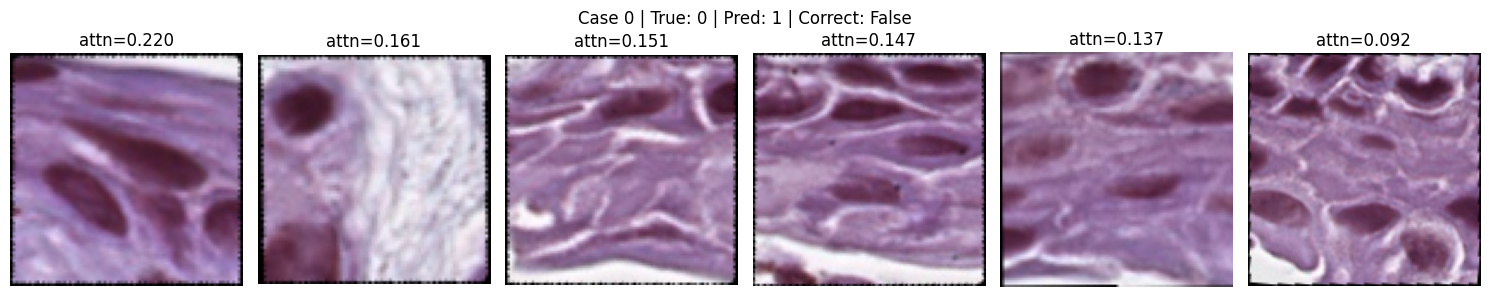


🧪 Case #5: True label = 1, Predicted = 1, Correct = True
Top patches with highest attention:
  - case_97_match_4_h&e_patch64.png: attention = 0.5879
  - case_97_match_4_h&e_patch65.png: attention = 0.2809
  - case_97_match_1_h&e_patch11.png: attention = 0.1143
  - case_97_match_2_h&e_patch89.png: attention = 0.0005
  - case_97_match_1_h&e_patch79.png: attention = 0.0004
  - case_97_match_1_h&e_patch12.png: attention = 0.0003


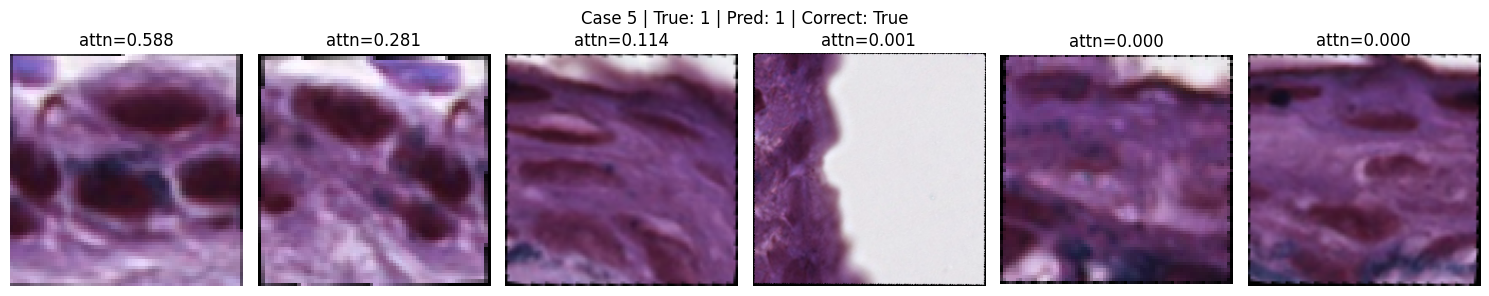


🧪 Case #6: True label = 1, Predicted = 1, Correct = True
Top patches with highest attention:
  - case_12_unmatched_2_h&e_patch16.png: attention = 0.2965
  - case_12_unmatched_2_h&e_patch54.png: attention = 0.2803
  - case_12_match_1_h&e_patch47.png: attention = 0.2630
  - case_12_unmatched_2_h&e_patch56.png: attention = 0.1488
  - case_12_match_1_h&e_patch20.png: attention = 0.0075
  - case_12_unmatched_2_h&e_patch65.png: attention = 0.0025


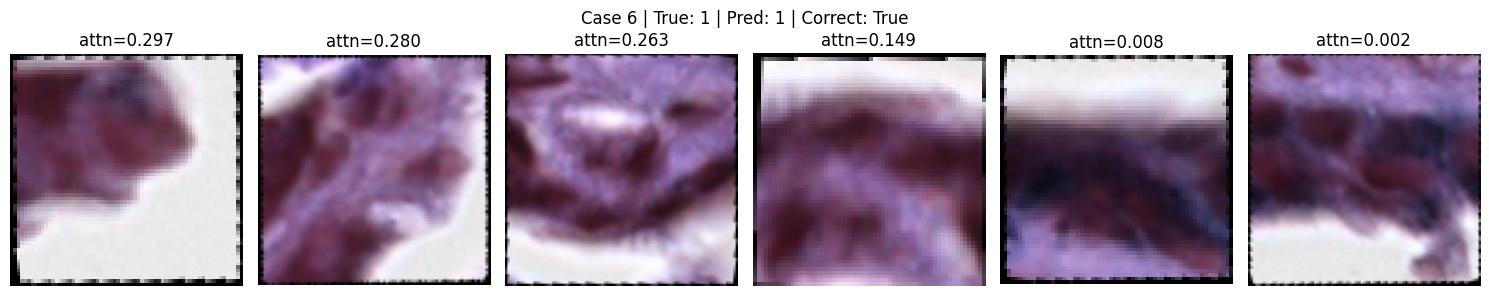


🧪 Case #4: True label = 1, Predicted = 1, Correct = True
Top patches with highest attention:
  - case_3_unmatched_3_h&e_patch89.png: attention = 0.0608
  - case_3_match_1_h&e_patch83.png: attention = 0.0169
  - case_3_unmatched_3_h&e_patch133.png: attention = 0.0165
  - case_3_match_1_h&e_patch46.png: attention = 0.0149
  - case_3_match_1_h&e_patch96.png: attention = 0.0149
  - case_3_unmatched_1_h&e_patch58.png: attention = 0.0141


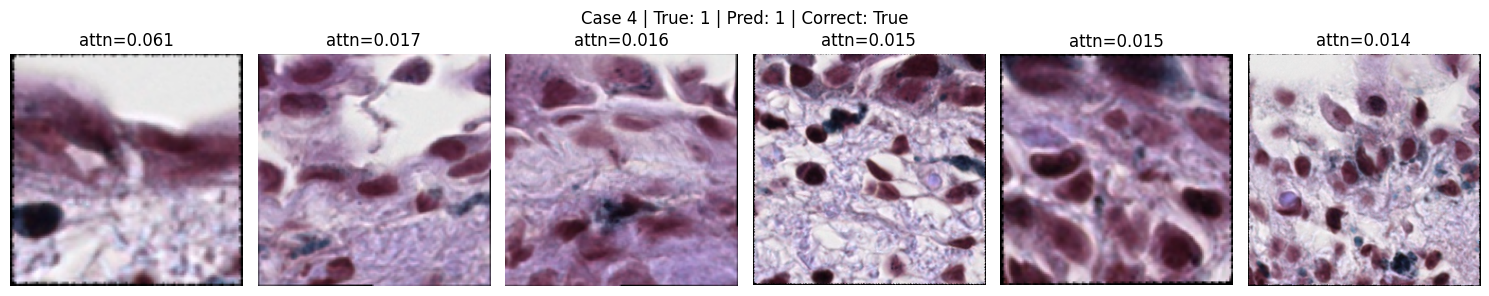


🧪 Case #1: True label = 0, Predicted = 1, Correct = False
Top patches with highest attention:
  - case_2_match_1_h&e_patch80.png: attention = 0.1392
  - case_2_match_1_h&e_patch81.png: attention = 0.1384
  - case_2_unmatched_1_h&e_patch35.png: attention = 0.1226
  - case_2_match_1_h&e_patch89.png: attention = 0.1209
  - case_2_match_1_h&e_patch90.png: attention = 0.1203
  - case_2_unmatched_3_h&e_patch80.png: attention = 0.1186


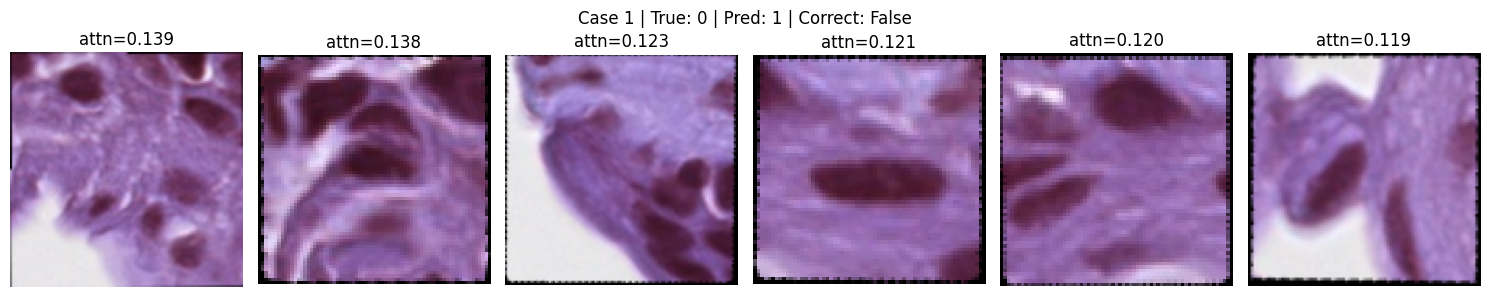


🧪 Case #3: True label = 1, Predicted = 1, Correct = True
Top patches with highest attention:
  - case_95_match_1_h&e_patch54.png: attention = 0.3479
  - case_95_match_1_h&e_patch48.png: attention = 0.2956
  - case_95_match_1_h&e_patch1.png: attention = 0.2713
  - case_95_match_1_h&e_patch68.png: attention = 0.0681
  - case_95_match_1_h&e_patch23.png: attention = 0.0068
  - case_95_match_1_h&e_patch51.png: attention = 0.0056


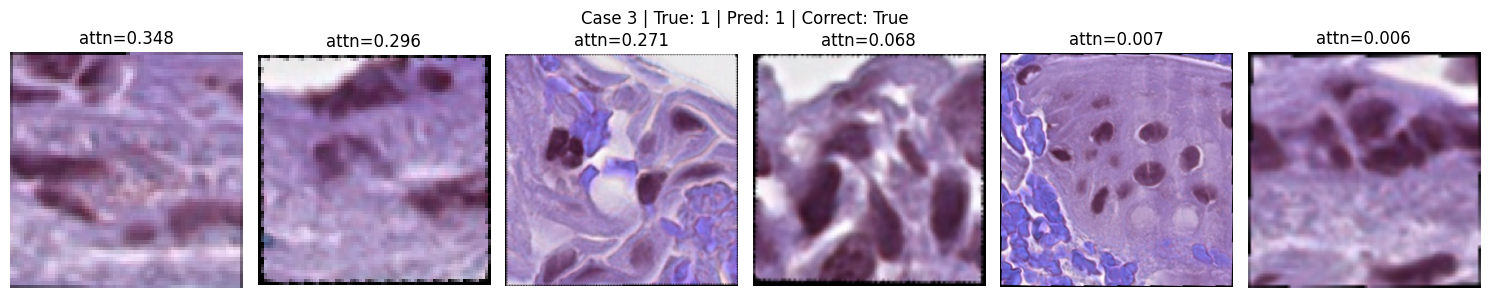


🧪 Case #2: True label = 1, Predicted = 1, Correct = True
Top patches with highest attention:
  - case_14_match_1_h&e_patch80.png: attention = 0.7333
  - case_14_match_1_h&e_patch44.png: attention = 0.2652
  - case_14_match_1_h&e_patch64.png: attention = 0.0002
  - case_14_match_4_h&e_patch11.png: attention = 0.0001
  - case_14_match_1_h&e_patch100.png: attention = 0.0001
  - case_14_match_1_h&e_patch62.png: attention = 0.0001


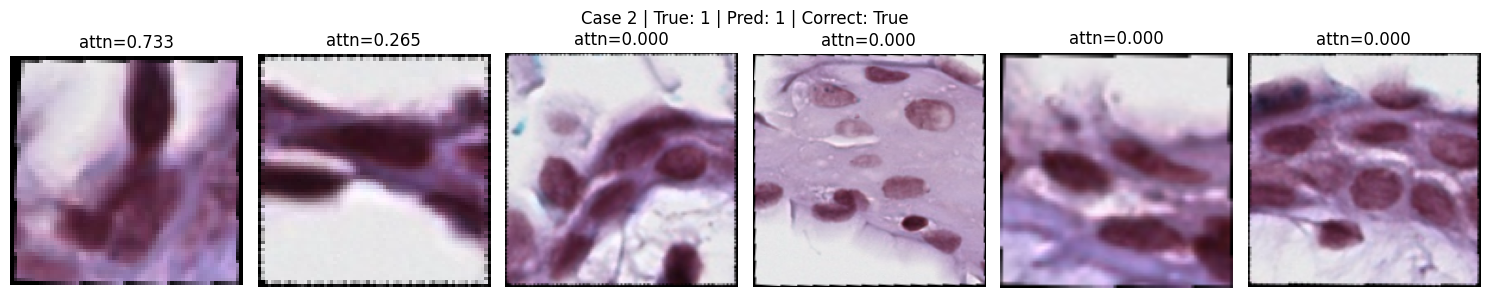

In [ ]:
visualize_top_attended_patches(model, test_ds, num_cases=7, top_k=6)

In [ ]:
def unnormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean

def visualize_top_attended_patches(model, test_ds, num_cases=3, top_k=5, bottom_k=5):
    model.eval()
    selected_indices = random.sample(range(len(test_ds)), num_cases)

    for idx in selected_indices:
        bag, label = test_ds[idx]
        bag = bag.unsqueeze(0).to(device)
        label = label.item()

        with torch.no_grad():
            logits, attn_weights = model(bag, return_attn_weights=True)
            pred = logits.argmax(dim=1).item()
            correct = (pred == label)
            attn_weights = attn_weights.squeeze(0).cpu().numpy()

        patch_paths = test_ds.bags[idx]
        bag_tensor = bag.squeeze(0).cpu()  # shape: (num_patches, 3, H, W)

        top_indices = attn_weights.argsort()[-top_k:][::-1]
        bottom_indices = attn_weights.argsort()[:bottom_k]

        def plot_patches(indices, title):
            plt.figure(figsize=(3 * len(indices), 3))
            for i, patch_idx in enumerate(indices):
                img_tensor = unnormalize(bag_tensor[patch_idx], [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                patch_img = transforms.ToPILImage()(img_tensor.clamp(0, 1))  # clamp to avoid overflow

                weight = attn_weights[patch_idx]
                plt.subplot(1, len(indices), i + 1)
                plt.imshow(patch_img)
                plt.axis('off')
                plt.title(f"α={weight:.3f}", fontsize=9)
            plt.suptitle(title, fontsize=12)
            plt.tight_layout()
            plt.show()


        print(f"\n🧪 Case #{idx} | ID={test_ds.bags[idx][0].split('case_')[1][:3]} | True: {label} | Pred: {pred} | Correct: {correct}")

        print("🔝 Top attended patches:")
        plot_patches(top_indices, f"Top {top_k} patches (Highest Attention)")

        print("🔻 Least attended patches:")
        plot_patches(bottom_indices, f"Bottom {bottom_k} patches (Lowest Attention)")



🧪 Case #1 | ID=2_u | True: 0 | Pred: 1 | Correct: False
🔝 Top attended patches:


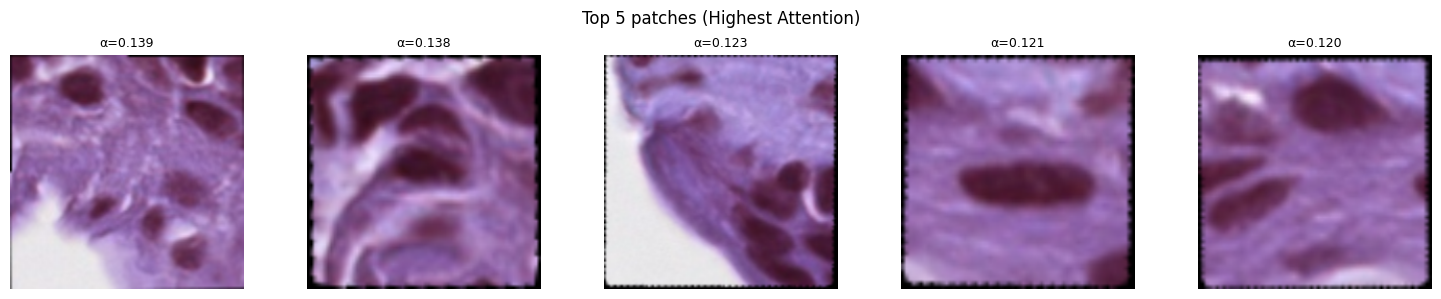

🔻 Least attended patches:


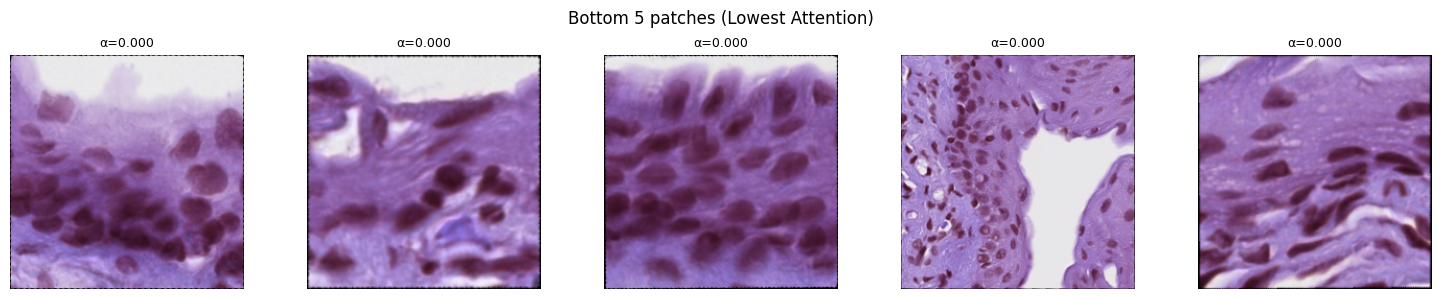


🧪 Case #2 | ID=14_ | True: 1 | Pred: 1 | Correct: True
🔝 Top attended patches:


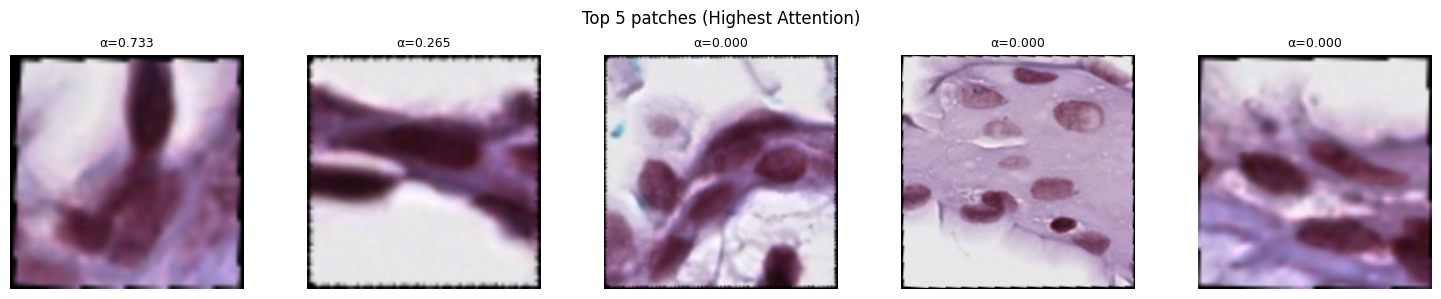

🔻 Least attended patches:


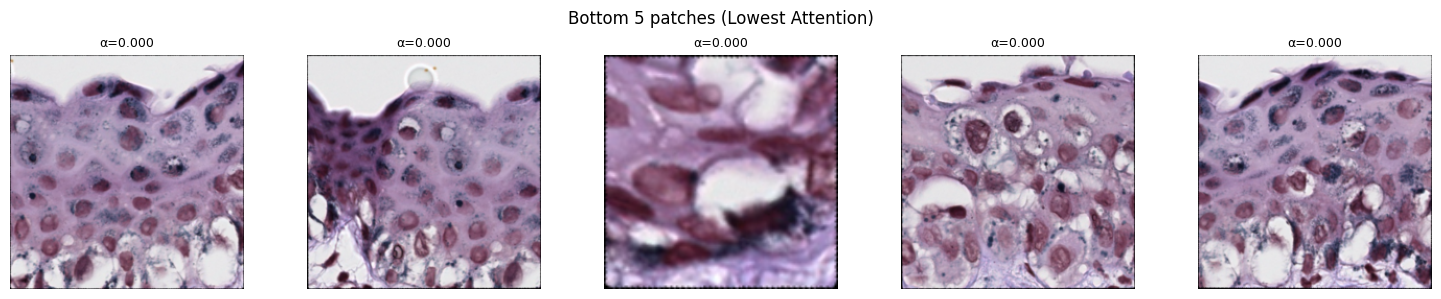


🧪 Case #6 | ID=12_ | True: 1 | Pred: 1 | Correct: True
🔝 Top attended patches:


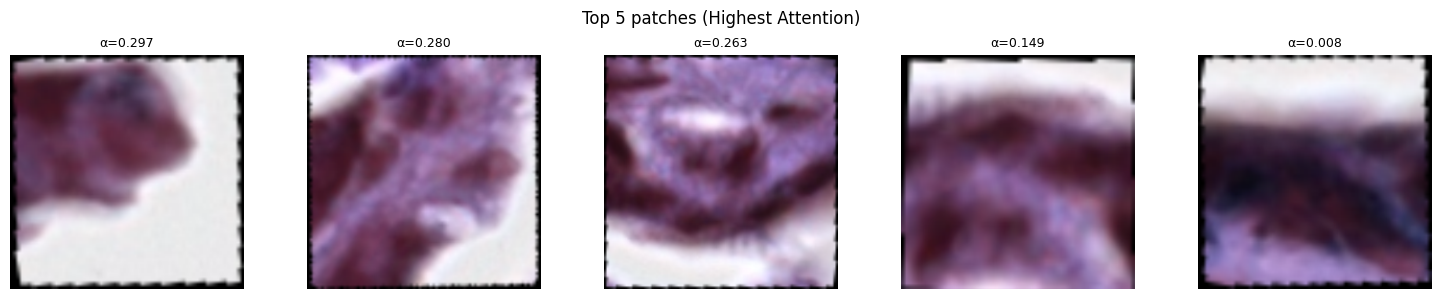

🔻 Least attended patches:


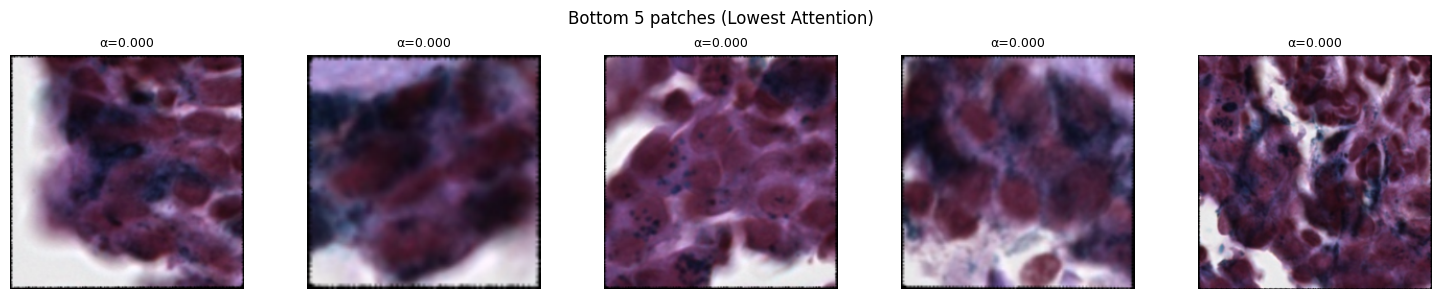

In [ ]:
visualize_top_attended_patches(model, test_ds, num_cases=3, top_k=5, bottom_k=5)
